In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-09-06 18:12:20 INFO ####################################################################################################


# system

In [3]:
##################################################################
#
# load data and net
#
##################################################################
# Dasetset  
config_file_path = "/home/lbu/project/PINN_DE/configs/train/scissor_space_deployable/config_pinn.py"
config = read_config_file(config_file_path)
config.dataset_path = "/home/lbu/project/PINN_DE/outputs/data/DynamicScissorSpaceDeployableDAE"

data_args = {
    "config": config,
    "logger": logger,
}
data = ln.data.get_data(**data_args)
train_loader, val_loader = data
y0, y, yt, data_t, physics_t = next(iter(val_loader))

data_t, y, yt = tensors_to_numpy(data_t, y, yt)
q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
all_states = np.concatenate([q, qt, qtt], axis=-1)

##################################################################
#
# Calculate the error
#
##################################################################
from dynamics import DynamicScissorSpaceDeployableDAE
calculator = DynamicScissorSpaceDeployableDAE(config, logger).calculator

energy = calculator.energy(q, qt) 
energy_error = calculator.energy(q, qt) - calculator.energy(q, qt)[0]

phi = calculator.phi(q, qt, qtt)
phi_t = calculator.phi_t(q, qt, qtt)
phi_tt = calculator.phi_tt(q, qt, qtt)
kinetic = calculator.kinetic(q, qt)
potential = calculator.potential(q, qt)

2023-09-06 18:12:20 INFO =================>
2023-09-06 18:12:20 INFO Start get dataset...
2023-09-06 18:12:20 INFO Loading dataset from path: /home/lbu/project/PINN_DE/outputs/data/DynamicScissorSpaceDeployableDAE
2023-09-06 18:12:20 INFO DynamicData is loaded


In [4]:
y.shape, physics_t.shape, y0.shape

((472, 144), torch.Size([472, 1]), torch.Size([1, 144]))

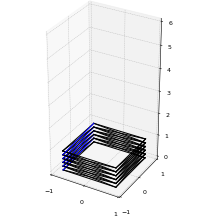

In [5]:
time = 0

fig = plt.figure(figsize=(5, 10), dpi=DPI)
ax = plt.subplot(1, 1, 1, projection='3d')

ax.plot([q[time, 0], q[time, 3]], [q[time, 1], q[time, 4]], [q[time, 2], q[time, 5]], 'k-')  # 12
ax.plot([q[time, 3], q[time, 6]], [q[time, 4], q[time, 7]], [q[time, 5], q[time, 8]], 'k-')  # 23
ax.plot([q[time, 6], q[time, 9]], [q[time, 7], q[time, 10]], [q[time, 8], q[time, 11]], 'k-')  # 34
ax.plot([q[time, 0], q[time, 9]], [q[time, 1], q[time, 10]], [q[time, 2], q[time, 11]], 'k-')  # 14

for k in range(1, 6):
    ax.plot([q[time, 12 * k], q[time, 12 * k + 3]],
             [q[time, 12 * k + 1], q[time, 12 * k + 4]],
             [q[time, 12 * k + 2], q[time, 12 * k + 5]], 'k-')  # 56
    ax.plot([q[time, 12 * k + 3], q[time, 12 * k + 6]],
             [q[time, 12 * k + 4], q[time, 12 * k + 7]],
             [q[time, 12 * k + 5], q[time, 12 * k + 8]], 'k-')  # 67
    ax.plot([q[time, 12 * k + 6], q[time, 12 * k + 9]],
             [q[time, 12 * k + 7], q[time, 12 * k + 10]],
             [q[time, 12 * k + 5], q[time, 12 * k + 11]], 'k-')  # 78
    ax.plot([q[time, 12 * k + 0], q[time, 12 * k + 9]],
             [q[time, 12 * k + 1], q[time, 12 * k + 10]],
             [q[time, 12 * k + 2], q[time, 12 * k + 11]], 'k-')  # 58
    ax.plot([q[time, 12 * k - 12], q[time, 12 * k + 3]],
             [q[time, 12 * k - 11], q[time, 12 * k + 4]],
             [q[time, 12 * k - 10], q[time, 12 * k + 5]], 'k-')  # 16
    ax.plot([q[time, 12 * k - 12], q[time, 12 * k + 9]],
             [q[time, 12 * k - 11], q[time, 12 * k + 10]],
             [q[time, 12 * k - 10], q[time, 12 * k + 11]], 'k-')  # 18
    ax.plot([q[time, 12 * k], q[time, 12 * k - 9]],
             [q[time, 12 * k + 1], q[time, 12 * k - 8]],
             [q[time, 12 * k + 2], q[time, 12 * k - 7]], 'k-')  # 25
    ax.plot([q[time, 12 * k - 9], q[time, 12 * k + 6]],
             [q[time, 12 * k - 8], q[time, 12 * k + 7]],
             [q[time, 12 * k - 7], q[time, 12 * k + 8]], 'k-')  # 27
    ax.plot([q[time, 12 * k - 6], q[time, 12 * k + 3]],
             [q[time, 12 * k - 5], q[time, 12 * k + 4]],
             [q[time, 12 * k - 4], q[time, 12 * k + 5]], 'k-')  # 36
    ax.plot([q[time, 12 * k - 6], q[time, 12 * k + 9]],
             [q[time, 12 * k - 5], q[time, 12 * k + 10]],
             [q[time, 12 * k - 4], q[time, 12 * k + 11]], 'k-')  # 38
    ax.plot([q[time, 12 * k + 0], q[time, 12 * k - 3]],
             [q[time, 12 * k + 1], q[time, 12 * k - 2]],
             [q[time, 12 * k + 2], q[time, 12 * k - 1]], 'k-')  # 45
    ax.plot([q[time, 12 * k + 6], q[time, 12 * k - 3]],
             [q[time, 12 * k + 7], q[time, 12 * k - 2]],
             [q[time, 12 * k + 8], q[time, 12 * k - 1]], 'b-')  # 47


ax.set_box_aspect([1, 1, 2])  # 调整Z轴的刻度距离图像
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([0, 1, 2, 3, 4, 5, 6])
ax.tick_params(labelsize=9) # font size for all axis

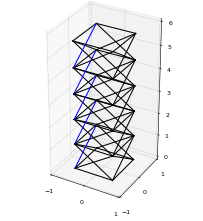

In [6]:
time = -1

fig = plt.figure(figsize=(5, 10), dpi=DPI)
ax = plt.subplot(1, 1, 1, projection='3d')

subfig = ax

subfig.plot([q[time, 0], q[time, 3]], [q[time, 1], q[time, 4]], [q[time, 2], q[time, 5]], 'k-')  # 12
subfig.plot([q[time, 3], q[time, 6]], [q[time, 4], q[time, 7]], [q[time, 5], q[time, 8]], 'k-')  # 23
subfig.plot([q[time, 6], q[time, 9]], [q[time, 7], q[time, 10]], [q[time, 8], q[time, 11]], 'k-')  # 34
subfig.plot([q[time, 0], q[time, 9]], [q[time, 1], q[time, 10]], [q[time, 2], q[time, 11]], 'k-')  # 14

for k in range(1, 6):
    subfig.plot([q[time, 12 * k], q[time, 12 * k + 3]],
             [q[time, 12 * k + 1], q[time, 12 * k + 4]],
             [q[time, 12 * k + 2], q[time, 12 * k + 5]], 'k-')  # 56
    subfig.plot([q[time, 12 * k + 3], q[time, 12 * k + 6]],
             [q[time, 12 * k + 4], q[time, 12 * k + 7]],
             [q[time, 12 * k + 5], q[time, 12 * k + 8]], 'k-')  # 67
    subfig.plot([q[time, 12 * k + 6], q[time, 12 * k + 9]],
             [q[time, 12 * k + 7], q[time, 12 * k + 10]],
             [q[time, 12 * k + 5], q[time, 12 * k + 11]], 'k-')  # 78
    subfig.plot([q[time, 12 * k + 0], q[time, 12 * k + 9]],
             [q[time, 12 * k + 1], q[time, 12 * k + 10]],
             [q[time, 12 * k + 2], q[time, 12 * k + 11]], 'k-')  # 58
    subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 3]],
             [q[time, 12 * k - 11], q[time, 12 * k + 4]],
             [q[time, 12 * k - 10], q[time, 12 * k + 5]], 'k-')  # 16
    subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 9]],
             [q[time, 12 * k - 11], q[time, 12 * k + 10]],
             [q[time, 12 * k - 10], q[time, 12 * k + 11]], 'k-')  # 18
    subfig.plot([q[time, 12 * k], q[time, 12 * k - 9]],
             [q[time, 12 * k + 1], q[time, 12 * k - 8]],
             [q[time, 12 * k + 2], q[time, 12 * k - 7]], 'k-')  # 25
    subfig.plot([q[time, 12 * k - 9], q[time, 12 * k + 6]],
             [q[time, 12 * k - 8], q[time, 12 * k + 7]],
             [q[time, 12 * k - 7], q[time, 12 * k + 8]], 'k-')  # 27
    subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 3]],
             [q[time, 12 * k - 5], q[time, 12 * k + 4]],
             [q[time, 12 * k - 4], q[time, 12 * k + 5]], 'k-')  # 36
    subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 9]],
             [q[time, 12 * k - 5], q[time, 12 * k + 10]],
             [q[time, 12 * k - 4], q[time, 12 * k + 11]], 'k-')  # 38
    subfig.plot([q[time, 12 * k + 0], q[time, 12 * k - 3]],
             [q[time, 12 * k + 1], q[time, 12 * k - 2]],
             [q[time, 12 * k + 2], q[time, 12 * k - 1]], 'k-')  # 45
    subfig.plot([q[time, 12 * k + 6], q[time, 12 * k - 3]],
             [q[time, 12 * k + 7], q[time, 12 * k - 2]],
             [q[time, 12 * k + 8], q[time, 12 * k - 1]], 'b-')  # 47


subfig.set_box_aspect([1, 1, 2])  # 调整Z轴的刻度距离图像
subfig.set_xticks([-1, 0, 1])
subfig.set_yticks([-1, 0, 1])
subfig.set_zticks([0, 1, 2, 3, 4, 5, 6])
subfig.tick_params(labelsize=9) # font size for all axis

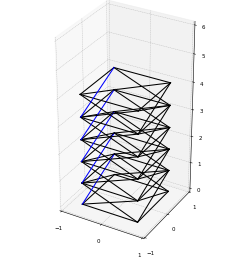

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# 设置参数
fps = 30  # 帧率
duration = len(data_t) # 动画持续时间（秒）
num_frames = int(duration / fps) # 帧数

# 创建动画
fig = plt.figure(figsize=(5, 10), dpi=DPI)
ax = plt.subplot(1, 1, 1, projection='3d')
subfig = ax
subfig.set_title('Animation')
subfig.set_xlabel('Position (m)')
subfig.set_ylabel('Position (m)')
plt.tight_layout()

def animate(frame):
    time = int(frame * fps)
    
    subfig.clear()
    
    subfig.plot([q[time, 0], q[time, 3]], [q[time, 1], q[time, 4]], [q[time, 2], q[time, 5]], 'k-')  # 12
    subfig.plot([q[time, 3], q[time, 6]], [q[time, 4], q[time, 7]], [q[time, 5], q[time, 8]], 'k-')  # 23
    subfig.plot([q[time, 6], q[time, 9]], [q[time, 7], q[time, 10]], [q[time, 8], q[time, 11]], 'k-')  # 34
    subfig.plot([q[time, 0], q[time, 9]], [q[time, 1], q[time, 10]], [q[time, 2], q[time, 11]], 'k-')  # 14

    for k in range(1, 6):
        subfig.plot([q[time, 12 * k], q[time, 12 * k + 3]],
                 [q[time, 12 * k + 1], q[time, 12 * k + 4]],
                 [q[time, 12 * k + 2], q[time, 12 * k + 5]], 'k-')  # 56
        subfig.plot([q[time, 12 * k + 3], q[time, 12 * k + 6]],
                 [q[time, 12 * k + 4], q[time, 12 * k + 7]],
                 [q[time, 12 * k + 5], q[time, 12 * k + 8]], 'k-')  # 67
        subfig.plot([q[time, 12 * k + 6], q[time, 12 * k + 9]],
                 [q[time, 12 * k + 7], q[time, 12 * k + 10]],
                 [q[time, 12 * k + 5], q[time, 12 * k + 11]], 'k-')  # 78
        subfig.plot([q[time, 12 * k + 0], q[time, 12 * k + 9]],
                 [q[time, 12 * k + 1], q[time, 12 * k + 10]],
                 [q[time, 12 * k + 2], q[time, 12 * k + 11]], 'k-')  # 58
        subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 3]],
                 [q[time, 12 * k - 11], q[time, 12 * k + 4]],
                 [q[time, 12 * k - 10], q[time, 12 * k + 5]], 'k-')  # 16
        subfig.plot([q[time, 12 * k - 12], q[time, 12 * k + 9]],
                 [q[time, 12 * k - 11], q[time, 12 * k + 10]],
                 [q[time, 12 * k - 10], q[time, 12 * k + 11]], 'k-')  # 18
        subfig.plot([q[time, 12 * k], q[time, 12 * k - 9]],
                 [q[time, 12 * k + 1], q[time, 12 * k - 8]],
                 [q[time, 12 * k + 2], q[time, 12 * k - 7]], 'k-')  # 25
        subfig.plot([q[time, 12 * k - 9], q[time, 12 * k + 6]],
                 [q[time, 12 * k - 8], q[time, 12 * k + 7]],
                 [q[time, 12 * k - 7], q[time, 12 * k + 8]], 'k-')  # 27
        subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 3]],
                 [q[time, 12 * k - 5], q[time, 12 * k + 4]],
                 [q[time, 12 * k - 4], q[time, 12 * k + 5]], 'k-')  # 36
        subfig.plot([q[time, 12 * k - 6], q[time, 12 * k + 9]],
                 [q[time, 12 * k - 5], q[time, 12 * k + 10]],
                 [q[time, 12 * k - 4], q[time, 12 * k + 11]], 'k-')  # 38
        subfig.plot([q[time, 12 * k + 0], q[time, 12 * k - 3]],
                 [q[time, 12 * k + 1], q[time, 12 * k - 2]],
                 [q[time, 12 * k + 2], q[time, 12 * k - 1]], 'k-')  # 45
        subfig.plot([q[time, 12 * k + 6], q[time, 12 * k - 3]],
                 [q[time, 12 * k + 7], q[time, 12 * k - 2]],
                 [q[time, 12 * k + 8], q[time, 12 * k - 1]], 'b-')  # 47
    
    subfig.set_box_aspect([1, 1, 2])  # 调整Z轴的刻度距离图像
    subfig.set_xticks([-1, 0, 1])
    subfig.set_yticks([-1, 0, 1])
    subfig.set_zticks([0, 1, 2, 3, 4, 5, 6])
    return []


ani = FuncAnimation(fig, animate, frames=num_frames, blit=True)

# # 保存为GIF文件
path = os.path.join(output_dir,'animation.gif')
ani.save(path, writer='pillow')

In [8]:
np.max(q)

5.628481628433706

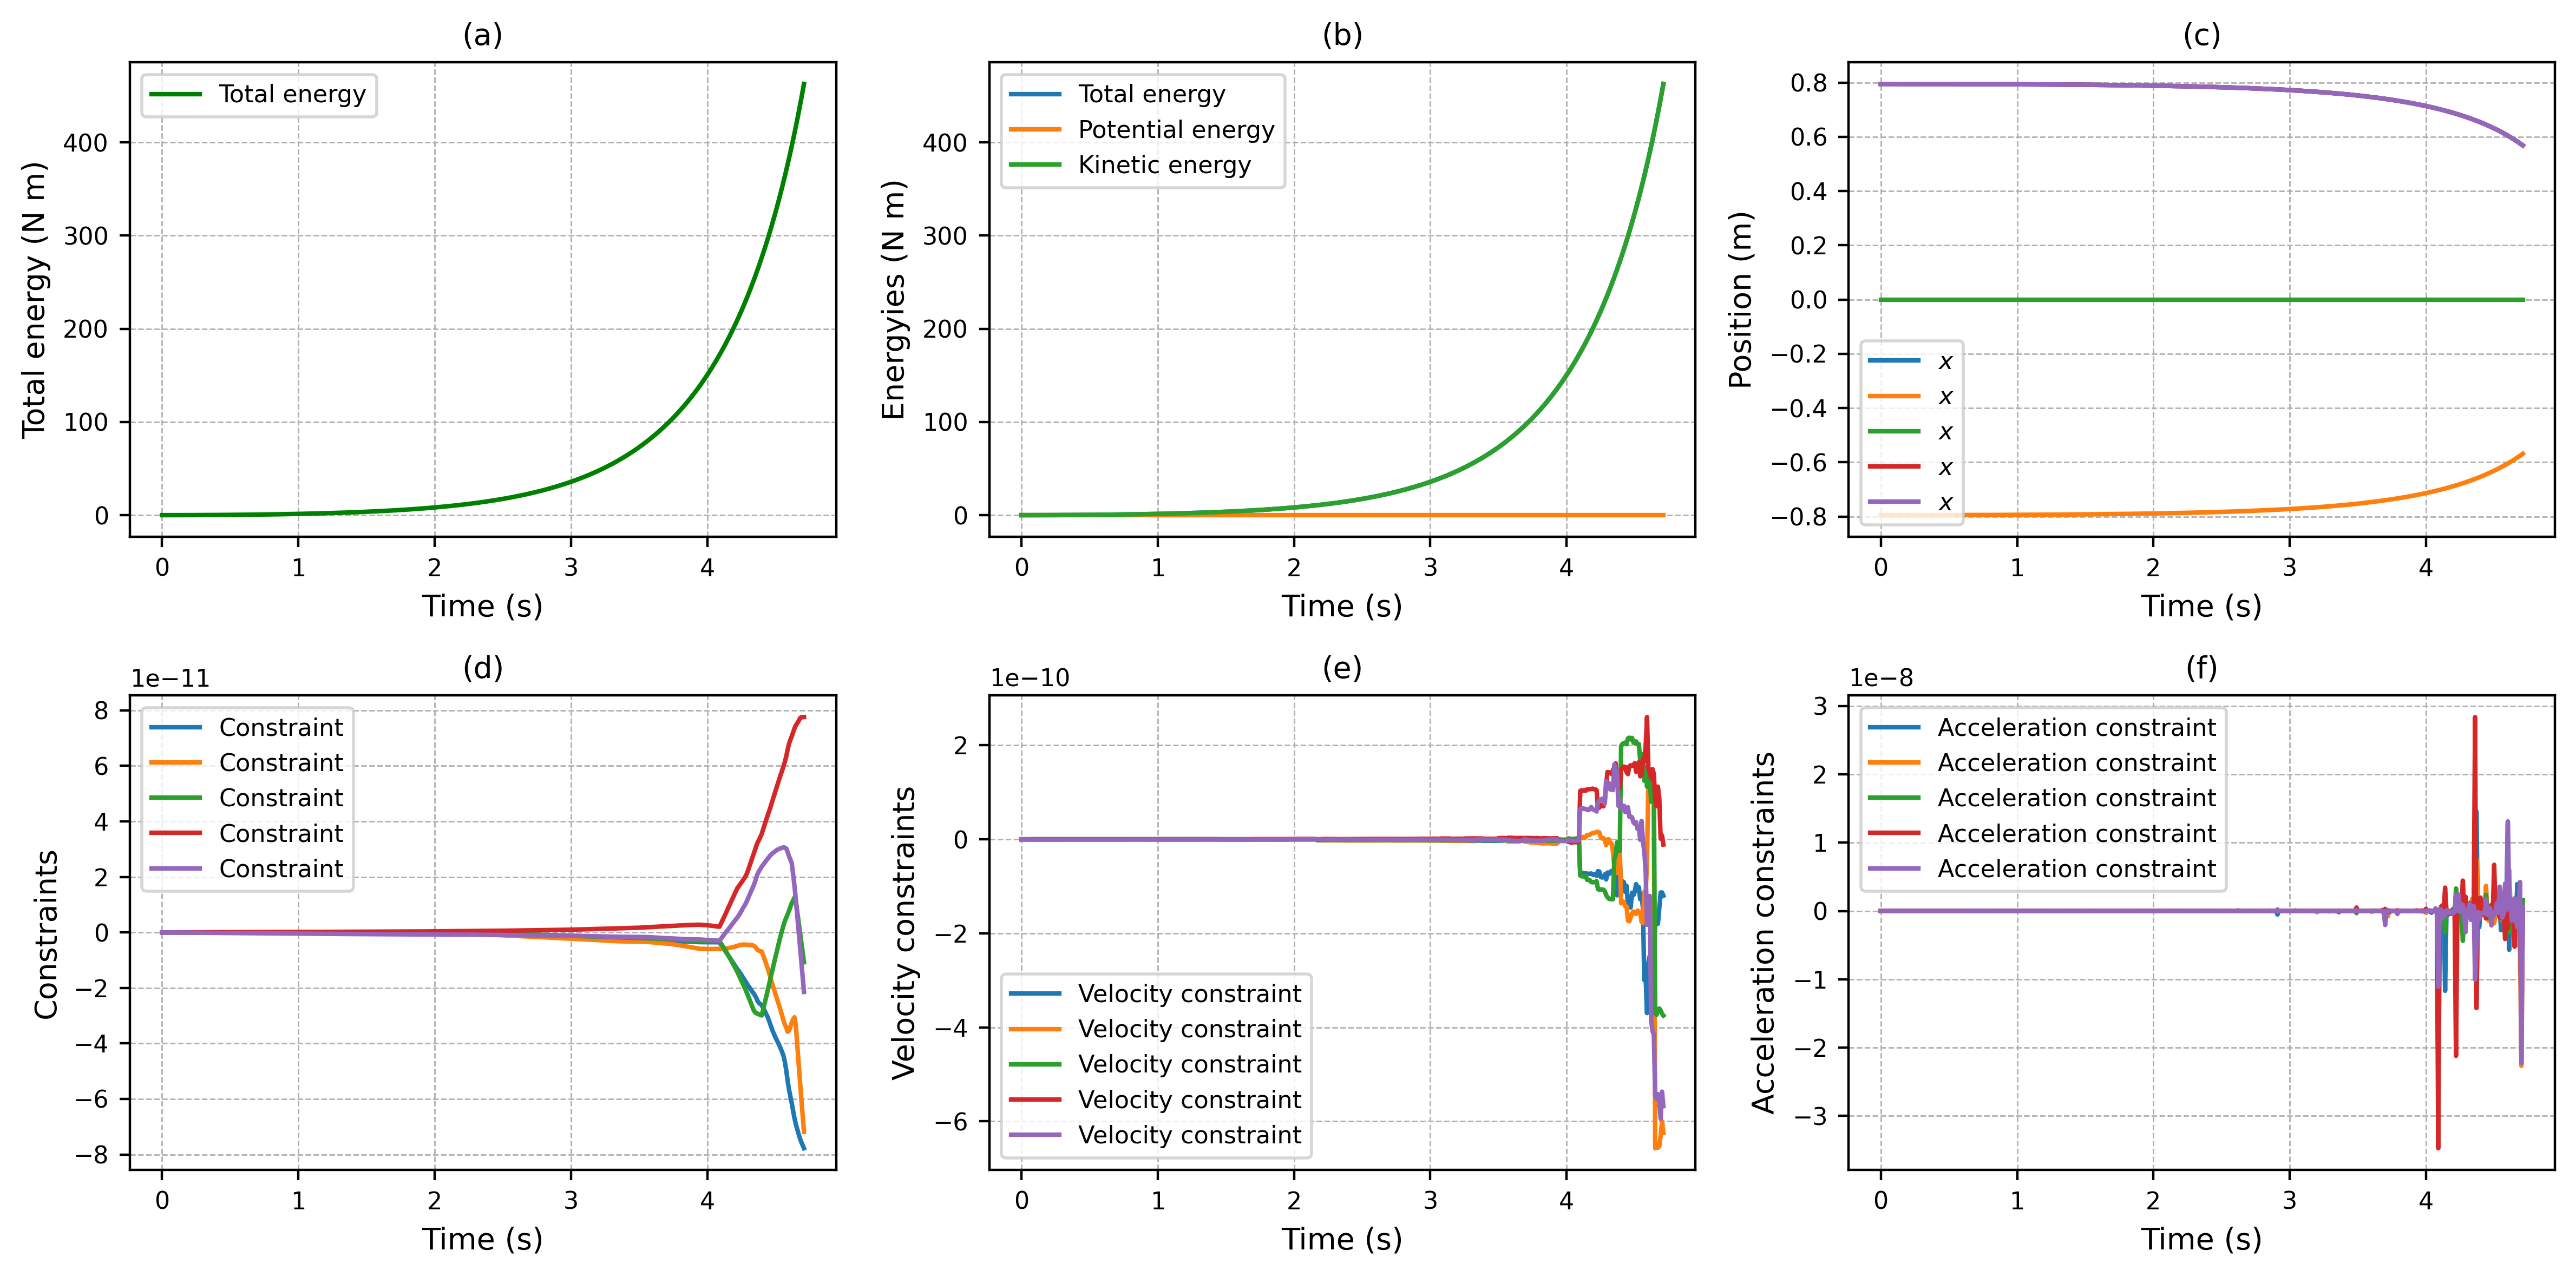

In [10]:
# fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=DPI)
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=400)

subfig = axs[0, 0]
subfig.set_title('(a)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Total energy (N m)')
subfig.plot(data_t, energy, 'g-', label='Total energy')
subfig.legend()

subfig = axs[0, 1]
subfig.set_title('(b)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Energyies (N m)')
subfig.plot(data_t, energy, label='Total energy')
subfig.plot(data_t, potential, label='Potential energy')
subfig.plot(data_t, kinetic, label='Kinetic energy')
subfig.legend()

subfig = axs[0, 2]
subfig.set_title('(c)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Position (m)')
subfig.plot(data_t, q[:, :5], label=r'$x$')
subfig.legend()

subfig = axs[1, 0]
subfig.set_title('(d)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Constraints')
subfig.plot(data_t, phi[:, :5], label='Constraint')
subfig.legend()

subfig = axs[1, 1]
subfig.set_title('(e)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Velocity constraints')
subfig.plot(data_t, phi_t[:, :5], label='Velocity constraint')
subfig.legend()

subfig = axs[1, 2]
subfig.set_title('(f)')
subfig.set_xlabel('Time (s)')
subfig.set_ylabel('Acceleration constraints')
subfig.plot(data_t, phi_tt[:, :5], label='Acceleration constraint')
subfig.legend()

plt.tight_layout()